<a href="https://colab.research.google.com/github/archie46/Computer-Vision-Labarotary/blob/main/CV10_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import zipfile
from pycocotools.coco import COCO
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import shutil
import matplotlib.pyplot as plt

In [ ]:
# Create a directory to save the annotations
annotation_dir = 'annotations'
os.makedirs(annotation_dir, exist_ok=True)

# Specify the COCO dataset URLs
coco_annotation_urls = [
    'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
]

# Download and extract the annotations
for url in coco_annotation_urls:
    filename = os.path.join(annotation_dir, os.path.basename(url))
    if not os.path.exists(filename):
        response = requests.get(url)
        with open(filename, 'wb') as f:
            f.write(response.content)

    # Extract the downloaded file
    # You can use a suitable unzip utility or Python's zipfile module.

# After this step, you should have the COCO dataset annotations in your specified directory.


In [ ]:
# Specify the path to the zip file
zip_file_path = 'annotations/annotations_trainval2017.zip'

# Specify the directory where you want to extract the contents
extraction_dir = 'annotations'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# After running this code, the contents of the zip file will be extracted to the specified directory.


In [ ]:
# Load the COCO annotations
dataType = 'train2017'  # Use 'train2017' or 'val2017' based on your needs
coco = COCO(f'{annotation_dir}/annotations/instances_{dataType}.json')

# Categories for cat and dog in COCO dataset
cat_category_id = coco.getCatIds(catNms=['cat'])[0]
dog_category_id = coco.getCatIds(catNms=['dog'])[0]

# Get image IDs containing cats and dogs
cat_image_ids = coco.getImgIds(catIds=[cat_category_id])
dog_image_ids = coco.getImgIds(catIds=[dog_category_id])

# Limit the number of cat and dog images to download
max_images_to_download = 50  # Change this to the desired number

# Combine cat and dog image IDs
cat_and_dog_image_ids = cat_image_ids[:max_images_to_download] + dog_image_ids[:max_images_to_download]

# Directory to save the cat and dog images
save_dir = 'images'
os.makedirs(save_dir, exist_ok=True)

# Download and save the cat and dog images
for image_id in cat_and_dog_image_ids:
    if coco.loadImgs(image_id):
      image_info = coco.loadImgs(image_id)[0]
      image_url = image_info['coco_url']
      image = requests.get(image_url).content
      with open(os.path.join(save_dir, f'{image_id}.jpg'), 'wb') as f:
          f.write(image)

loading annotations into memory...
Done (t=12.38s)
creating index...
index created!


In [ ]:
# Step 1: Load and preprocess the images
image_folder = "images"
image_paths = [os.path.join(image_folder, image_file) for image_file in os.listdir(image_folder)]

images = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    images.append(image)

# Step 2: Extract feature vectors from the images
feature_vectors = []
for image in images:
    # You can use different feature extraction methods here (e.g., HOG, color histograms).
    # Here, we resize the image to a fixed size and then flatten it into a 1D array.
    image = cv2.resize(image, (100, 100))
    feature_vector = image.ravel()
    feature_vectors.append(feature_vector)

# Step 3: Standardize the feature vectors
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(feature_vectors)

# Step 4: Apply PCA to reduce dimensionality if needed
# You can skip this step or adjust the number of components as per your needs.
pca = PCA(n_components=50)
reduced_feature_vectors = pca.fit_transform(scaled_feature_vectors)

# Step 5: Create a K-means model and cluster the images
kmeans = KMeans(n_clusters=2,n_init='auto')
kmeans.fit(reduced_feature_vectors)

# Step 6: Get cluster assignments for each image
cluster_assignments = kmeans.labels_

# Step 7: Organize images into clusters
clusters = [[] for _ in range(2)]
for i, image_path in enumerate(image_paths):
    cluster_idx = cluster_assignments[i]
    clusters[cluster_idx].append(image_path)

for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1} contains {len(cluster)} images.")

# Step 8: Create directories for the clusters
output_dir = "output_clusters"
os.makedirs(output_dir, exist_ok=True)

for i, cluster in enumerate(clusters):
    cluster_dir = os.path.join(output_dir, f"cluster_{i + 1}")
    os.makedirs(cluster_dir, exist_ok=True)

    # Copy or move the images to their respective cluster directories
    for image_path in cluster:
        image_filename = os.path.basename(image_path)
        shutil.copy(image_path, os.path.join(cluster_dir, image_filename))
        # Use shutil.move if you want to move the images instead of copying.

print("Images have been saved to their respective cluster directories.")

Cluster 1 contains 52 images.
Cluster 2 contains 47 images.
Images have been saved to their respective cluster directories.


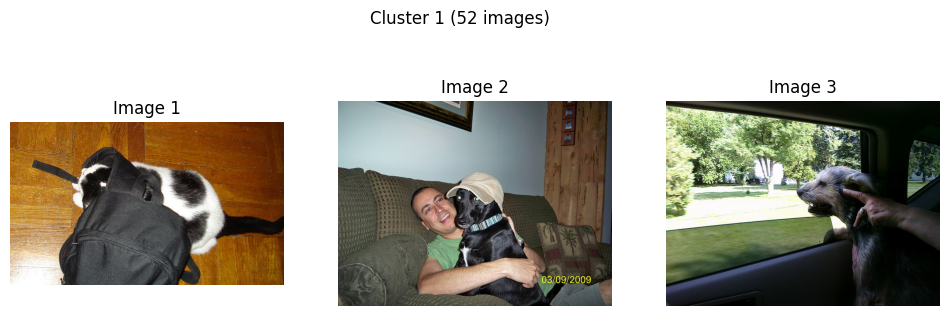

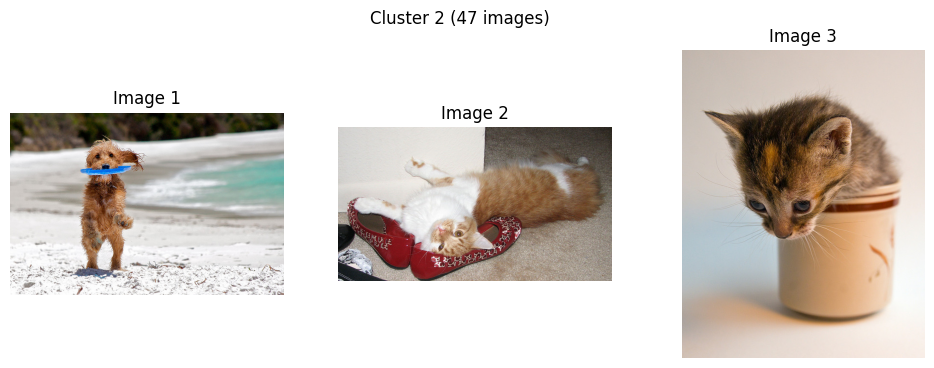

In [ ]:
for i, cluster in enumerate(clusters):
    num_images_to_display = min(len(cluster), 3)
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Cluster {i + 1} ({len(cluster)} images)")

    for i in range(num_images_to_display):
        image_path = cluster[i]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(image)
        plt.title(f"Image {i + 1}")
        plt.axis('off')

    plt.show()